# Линейная классификация

## Подключение библиотек

In [ ]:
import numpy as np
import csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate
import matplotlib.pyplot as plt

## 1. Данные

### Разделение данных на тренировочные и тестовые

In [ ]:
features_train = []
prices = []

with open('./dataset/preprocessed_train.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    feature_titles = [key for key in reader.fieldnames if key != 'Survived']
    
    for row in reader:
        sale_price = float(row['Survived'])
        feature_values = []
        for feature in feature_titles:
            value = row[feature]
            feature_values.append(float(value))
        
        features_train.append(feature_values)
        prices.append(sale_price)

features_train = np.array(features_train)
prices = np.array(prices)

x_train, x_test, y_train, y_test = train_test_split(
    features_train, prices, 
    test_size=0.3, 
    random_state=42
)

numerical_features = ['Age', 'SibSp', 'Parch', 'Fare']
scaler = StandardScaler()

for i, feature in enumerate(feature_titles):
    if feature in numerical_features:
        x_train[:, i] = scaler.fit_transform(x_train[:, i].reshape(-1, 1)).flatten()
        x_test[:, i] = scaler.transform(x_test[:, i].reshape(-1, 1)).flatten()

### Визуализация данных

In [148]:
table_data = []
headers = ["Index"] + feature_titles + ["Survived"]

for i, (feat_scaled, price) in enumerate(zip(x_train, y_train)):
    row = [i] + list(feat_scaled) + [price]
    table_data.append(row)

print(tabulate(table_data[:20], headers=headers, tablefmt="grid", numalign="left"))

+---------+----------+-------+-----------+-----------+-----------+------------+------------+------------+
| Index   | Pclass   | Sex   | Age       | SibSp     | Parch     | Fare       | Embarked   | Survived   |
+=========+==========+=======+===========+===========+===========+============+============+============+
| 0       | 1        | 0     | -1.85798  | -0.474161 | 1.99885   | 0.980998   | 2          | 1          |
+---------+----------+-------+-----------+-----------+-----------+------------+------------+------------+
| 1       | 3        | 0     | -0.278303 | -0.474161 | -0.479327 | -0.469634  | 2          | 0          |
+---------+----------+-------+-----------+-----------+-----------+------------+------------+------------+
| 2       | 3        | 1     | -2.08365  | 0.348687  | 0.759763  | -0.406136  | 2          | 1          |
+---------+----------+-------+-----------+-----------+-----------+------------+------------+------------+
| 3       | 2        | 0     | 0.549149  | 0.3

### Оставляем только два признака (Age, Fare)

In [149]:
x_train = x_train[:, [2, 5]]
x_test = x_test[:, [2, 5]]

### Визуализируем оставшиеся данные

In [150]:
table_data = []
headers = ["Index", "Age", "Fare", "Survived"]

for i, (feat_scaled, price) in enumerate(zip(x_train, y_train)):
    row = [i] + list(feat_scaled) + [price]
    table_data.append(row)

print(tabulate(table_data[:20], headers=headers, tablefmt="grid", numalign="left"))

+---------+-----------+------------+------------+
| Index   | Age       | Fare       | Survived   |
+=========+===========+============+============+
| 0       | -1.85798  | 0.980998   | 1          |
+---------+-----------+------------+------------+
| 1       | -0.278303 | -0.469634  | 0          |
+---------+-----------+------------+------------+
| 2       | -2.08365  | -0.406136  | 1          |
+---------+-----------+------------+------------+
| 3       | 0.549149  | -0.0802318 | 0          |
+---------+-----------+------------+------------+
| 4       | 1.07571   | -0.109651  | 0          |
+---------+-----------+------------+------------+
| 5       | 0.699595  | 2.38538    | 0          |
+---------+-----------+------------+------------+
| 6       | 0.173034  | -0.109651  | 1          |
+---------+-----------+------------+------------+
| 7       | 0.0225886 | -0.466609  | 0          |
+---------+-----------+------------+------------+
| 8       | -0.804863 | -0.461706  | 0          |


## 2. Построение модели

1. **Предсказание (Sigmoid функция):**
   $$
   y_{\text{pred}} = \frac{1}{1 + e^{-(X \cdot \text{w})}}
   $$

2. **Градиент:**
   $$
   \text{grad} = \frac{1}{L} \cdot X^T \cdot (y_{\text{pred}} - Y)
   $$
   где:
   - $ L $ — количество объектов в выборке,
   - $ X $ — матрица признаков,
   - $ Y $ — вектор истинных меток.

3. **Обновление весов:**
   $$
   \text{w} = \text{w} - \text{lr} \cdot \text{grad}
   $$
   где:
   - $ \text{lr} $ — скорость обучения (learning rate).

In [151]:
class LinearClassificator:
    def __init__(self, iterations=10**100, lr=0.001, eps=1e-6, degree=1):
        self.iterations = iterations
        self.lr = lr
        self.eps = eps
        self.degree = degree
        self.weights = None  
        self.coef_ = None
        self.intercept_ = None  
        self.gradHistory = []
        
    def addIntercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
        
    def addPolynomialFeatures(self, X):
        if self.degree <= 1:
            return X  
        poly_features = [X ** i for i in range(1, self.degree + 1)]
        return np.hstack(poly_features)      
    
    def fit(self, X, Y):
        self.gradHistory.clear()
        X = self.addPolynomialFeatures(X)
        X = self.addIntercept(X)
        self.weights = np.zeros(X.shape[1])
        
        for i in range(self.iterations):
            y_pred = 1 / (1 + np.exp(-(X @ self.weights)))
            grad = (1 / X.shape[0]) * (X.T @ (y_pred - Y))
            self.weights -= self.lr * grad
            
            self.gradHistory.append(np.linalg.norm(grad))
            if i > 0 and np.linalg.norm(grad) < self.eps:
                print(f"Остановка на итерации {i} из-за маленького изменения MSE.")
                break
        
    def predict(self, X):
        X = self.addPolynomialFeatures(X)
        X = self.addIntercept(X)
        return X @ self.weights
    
    def getAccuracy(self, X, Y):
        X = self.addPolynomialFeatures(X)
        X = self.addIntercept(X)
        y_pred = np.sign((X @ self.weights))
        y_pred = np.where(y_pred > 0, 1, 0)
        TP = np.sum((y_pred == 1) & (Y == 1))
        FP = np.sum((y_pred == 1) & (Y == 0))
        TN = np.sum((y_pred == 0) & (Y == 0))
        FN = np.sum((y_pred == 0) & (Y == 1))
        print(f"TP: {TP}, FP: {FP}, TN: {TN}, FN: {FN}")
        
        precision = TP / (TP + FP) 
        recall = TP / (TP + FN)
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        return (2 * precision * recall) / (precision + recall)
        

## 3. Тренировка 

Остановка на итерации 444752 из-за маленького изменения MSE.


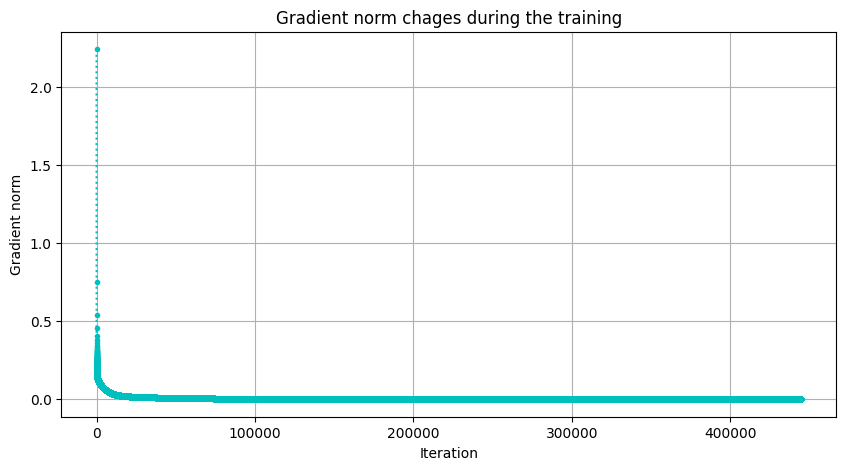

In [152]:
model = LinearClassificator(degree=3)
model.fit(x_train, y_train)

gradHistory = model.gradHistory
plt.figure(figsize=(10, 5))
plt.plot(gradHistory, marker='.', linestyle=':', color='c')
plt.title('Gradient norm chages during the training')
plt.xlabel('Iteration')
plt.ylabel('Gradient norm')
plt.grid(True)
plt.show()

## 4. Оценка качества модели

In [153]:
print(f"Accuracy: {model.getAccuracy(x_test, y_test)}")

TP: 40, FP: 16, TN: 141, FN: 71
Precision: 0.7142857142857143
Recall: 0.36036036036036034
Accuracy: 0.47904191616766467


## 5. Визуализация модели

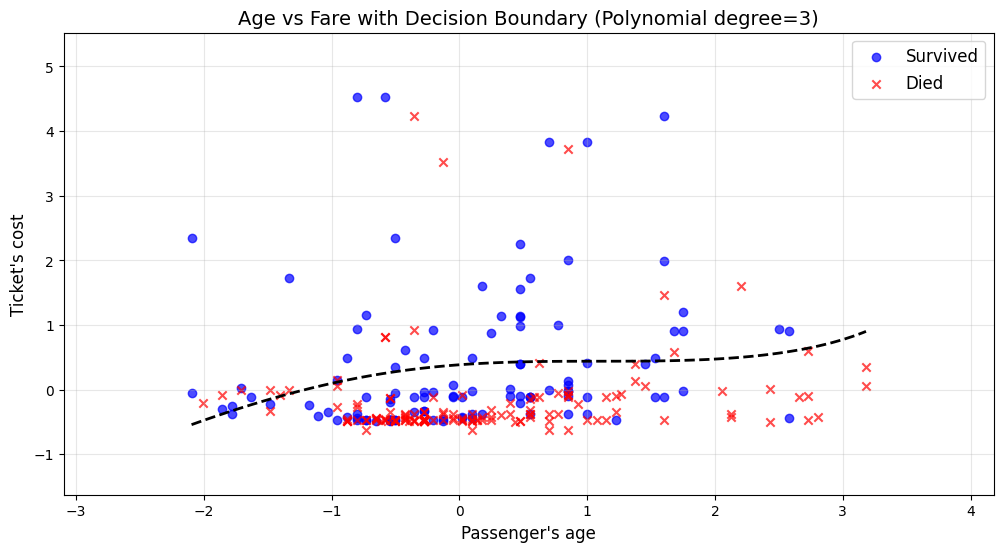

In [ ]:
plt.figure(figsize=(12, 6))

age = x_test[:, 0]
fare = x_test[:, 1]
age_survived = age[y_test == 1]  
age_died = age[y_test == 0] 
fare_survived = fare[y_test == 1]  
fare_died = fare[y_test == 0] 

plt.scatter(age_survived, fare_survived, color='blue', label='Survived', alpha=0.7, marker='o')
plt.scatter(age_died, fare_died, color='red', label='Died', alpha=0.7, marker='x')

weights = model.weights
degree = model.degree 

x1_vals = np.linspace(age.min(), age.max(), 100)
x2_vals = np.linspace(fare.min(), fare.max(), 100)
X1, X2 = np.meshgrid(x1_vals, x2_vals)

Z = weights[0] * np.ones_like(X1) 
current_weight_idx = 1

for d in range(1, degree + 1):
    if current_weight_idx < len(weights):
        Z += weights[current_weight_idx] * (X1 ** d) 
        current_weight_idx += 1
    if current_weight_idx < len(weights):
        Z += weights[current_weight_idx] * (X2 ** d) 
        current_weight_idx += 1

plt.contour(X1, X2, Z, levels=[0], colors='k', linestyles='dashed', linewidths=2)
plt.xlabel("Passenger's age", fontsize=12)
plt.ylabel("Ticket's cost", fontsize=12)
plt.title(f'Age vs Fare with Decision Boundary (Polynomial degree={degree})', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xlim(age.min() - 1, age.max() + 1)
plt.ylim(fare.min() - 1, fare.max() + 1)
plt.show()